In [3]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse.linalg import eigs


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='./Student', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add

CUDA: True cuda:0


In [4]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = os.path.join('./data/PEMS04/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


In [5]:
graph_signal_matrix_filename = './data/PEMS04/pems04.npz'
batch_size = 16
num_of_weeks = 1
num_of_days = 1
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

load file: ./data/PEMS04/pems04_r1_d1_w1_astcgn
train: torch.Size([13575, 307, 1, 12]) torch.Size([13575, 307, 12])
val: torch.Size([1697, 307, 1, 12]) torch.Size([1697, 307, 12])
test: torch.Size([1697, 307, 1, 12]) torch.Size([1697, 307, 12])


In [6]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

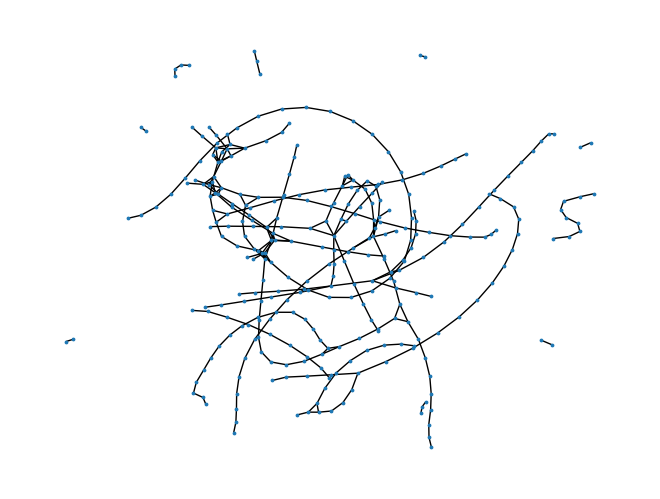

In [7]:
id_filename = None
adj_filename = './data/PEMS04/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

In [8]:
from model.ASTGCN import ASTGCN

In [9]:
nb_block = 1
in_channels = 1
K = 3
nb_chev_filter =64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12
dropout=0.03
nb_chev_filterstdn = 64
nb_time_filterstdn = 64
nb_blockstdn = 1
dropouts=0.01
Student=ASTGCN( nb_blockstdn, in_channels, K, nb_chev_filterstdn, nb_time_filterstdn, time_strides, num_for_predict, len_input, num_of_vertices,dropouts).to(DEVICE)
print(Student)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_dropout): Dropout2d(p=0.01, inplace=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), stride=(1, 1))
)


## Intialized student model

In [10]:
#------------------------------------------------------
# weight_decay=1e-3
optimizerStudent = optim.Adam(Student.parameters(), lr=1e-3,weight_decay=1e-6)

print('Teacher\'s state_dict:')
total_param = 0
for param_tensor in Student.state_dict():
    print(param_tensor, '\t', Student.state_dict()[param_tensor].size(), '\t', Student.state_dict()[param_tensor].device)
    total_param += np.prod(Student.state_dict()[param_tensor].size())
print('Student\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizerStudent.state_dict():
    print(var_name, '\t', optimizerStudent.state_dict()[var_name])


Teacher's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._resid

In [11]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


In [12]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,ytil,y):
        return torch.sqrt(self.mse(ytil,y))

In [13]:
T=4 #temprature for softer distribution
lambda_kd = 0.7 # trade off teacher weights to students, 70% teach 30% stud
masked_flag=0
criterionStudent=RMSELoss().to(DEVICE)

criterion_masked = masked_mae
loss_function = 'mae'

metric_method = 'unmask'
missing_value=0.0

if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [14]:
ValLoss=[]
TrainLoss=[]

In [15]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 20 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        ValLoss.append(validation_loss)
        sw.add_scalar('validation_loss', validation_loss, epoch)
        print("rata rata val_loss",validation_loss,"pada epoch:",epoch)
    return validation_loss

In [16]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [16]:
#Student kd
for epoch in range(40):
    params_filename = os.path.join('./Student/', 'checkpoint_%s.pth' % epoch)
    
    tmp=[]
    Student.train()  # ensure dropout layers are in train mode
    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
        optimizerStudent.zero_grad()
        P_s = Student(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12]) Ps
        P_sloss=criterionStudent(P_s,labels)
        loss=P_sloss
        loss.backward()
        optimizerStudent.step()
        training_loss = loss.item()
        tmp.append(training_loss)
        global_step += 1
        sw.add_scalar('training_loss',training_loss, global_step)

        if global_step % 100 == 0:
            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))
    rtloss_t=sum(tmp) / len(tmp)
    TrainLoss.append(rtloss_t)
    print("rata rata Distilation loss",rtloss_t,"pada epoch:",epoch)
    val_loss = compute_val_loss_mstgcn(Student, val_loader, criterionStudent, masked_flag, missing_value, sw, epoch,edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': best_epoch,
            'model_state': Student.state_dict(),
            'optimizer_state': optimizerStudent.state_dict()
        }
        torch.save(checkpoint, params_filename)
        print('save parameters to file: %s' % params_filename)

print('best epoch:', best_epoch)
path=os.path.join("./Student/",'losshistval.npy')
path1=os.path.join("./Student/",'losshisttrain.npy')
np.save(path,ValLoss)
np.save(path1,TrainLoss)

global step: 100, training loss: 193.51, time: 32.89s
global step: 200, training loss: 157.36, time: 61.45s
global step: 300, training loss: 87.92, time: 89.63s
global step: 400, training loss: 68.69, time: 118.00s
global step: 500, training loss: 70.65, time: 146.74s
global step: 600, training loss: 64.25, time: 175.67s
global step: 700, training loss: 57.97, time: 204.29s
global step: 800, training loss: 59.35, time: 233.31s
rata rata Distilation loss 101.63013871173837 pada epoch: 0
validation batch 1 / 107, loss: 32.83
validation batch 21 / 107, loss: 46.54
validation batch 41 / 107, loss: 52.33
validation batch 61 / 107, loss: 47.27
validation batch 81 / 107, loss: 56.88
validation batch 101 / 107, loss: 57.67
rata rata val_loss 51.590435562846814 pada epoch: 0
save parameters to file: ./Student/checkpoint_0.pth
global step: 900, training loss: 57.78, time: 279.83s
global step: 1000, training loss: 43.74, time: 309.22s
global step: 1100, training loss: 62.59, time: 339.88s
global 

* label smoothing

In [19]:
epoch =  36
params_filename = os.path.join('./Student/', 'checkpoint_%s.pth' % epoch)
loaded_checkpoint=torch.load(params_filename)
epoch=loaded_checkpoint['epoch']
Student.load_state_dict(loaded_checkpoint['model_state'])
optimizerStudent.load_state_dict(loaded_checkpoint['optimizer_state'])
Student.eval()

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_dropout): Dropout2d(p=0.01, inplace=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), stride=(1, 1))
)

In [ ]:
#20637.03s

In [21]:

from time import process_time as ps
start = ps() 
Student.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = Student(encoder_inputs, edge_index_data)
        loss = criterionStudent(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 1 == 0:
            print('test_loss batch %s / %s, loss: %.2f ' % (batch_index + 1, test_loader_length, loss.item()))

    
    test_loss = sum(tmp) / len(tmp)
end = ps()
print("rate test : ",end-start, "second", "Test loss : ",test_loss)  
    
# print(test_loss)
np.save('./ANALYSIS/no_kd/test.npy',tmp)

test_loss batch 1 / 107, loss: 16.27 
test_loss batch 2 / 107, loss: 32.86 
test_loss batch 3 / 107, loss: 50.04 
test_loss batch 4 / 107, loss: 54.15 
test_loss batch 5 / 107, loss: 47.67 
test_loss batch 6 / 107, loss: 43.31 
test_loss batch 7 / 107, loss: 45.33 
test_loss batch 8 / 107, loss: 46.52 
test_loss batch 9 / 107, loss: 42.27 
test_loss batch 10 / 107, loss: 46.53 
test_loss batch 11 / 107, loss: 44.98 
test_loss batch 12 / 107, loss: 41.36 
test_loss batch 13 / 107, loss: 46.97 
test_loss batch 14 / 107, loss: 43.06 
test_loss batch 15 / 107, loss: 32.20 
test_loss batch 16 / 107, loss: 30.71 
test_loss batch 17 / 107, loss: 25.97 
test_loss batch 18 / 107, loss: 19.10 
test_loss batch 19 / 107, loss: 18.30 
test_loss batch 20 / 107, loss: 17.34 
test_loss batch 21 / 107, loss: 23.12 
test_loss batch 22 / 107, loss: 29.77 
test_loss batch 23 / 107, loss: 47.93 
test_loss batch 24 / 107, loss: 37.17 
test_loss batch 25 / 107, loss: 30.82 
test_loss batch 26 / 107, loss: 38